# CHANGE-POINT DETECTION: DIFFERENT TYPES OF CHANGES

Welcome to Part 3 of our series about *change-point detection*, sometimes also called *change-point analysis*. In this series we want to explain how a changepoint is defined and also how it can be detected using standard packages.

A general introduction to change-point analysis can be found in our [introduction notebook](./CP-detection1-intro.ipynb).

Another overview on change-point detection can be found in our [blog series](https://www.iese.fraunhofer.de/blog/change-point-detection/)

Recall from our [previous blog](./CP-detection2-runtime-aspects.ipynb) that we focussed on *change in mean* only. But this time we want to consider other changes as well. 

Also, we will see that sometimes it is sufficient to **tune** your search model and sometimes you need to **select a different** search method to get accurate changepoints. With this, we will see ideas how to find suitable methods to discover the changepoints you would like to discover.

Let's import some libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
from pathlib import Path
import zipfile
import urllib

## 1) The UCI hydraulic dataset

In this blog we will focus on *change in mean* again. An intersting **realistic** dataset is the UCI hydraulic dataset which contains real measurements of a hydraulic test rig based on multi sensor data. A full description of the experiment can be found in (Helwig et al. 2015).

For a start, we provide some code so you can easily *download* the data from the UCI repository (https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems ) and the data will be unzipped automatically. For simplicity, the data will be saved in the local working directory.

*The required space is about  530 megabytes!*

In [2]:
# download of the data
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip',
                           "data.zip")
# unzip the data
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall()
print("download and unzip of data succesful")

download and unzip of data succesful


The dataset contains different measurement data like pressure, temperature and so on. Alltogether, there are 2205 measurements with different conditions.

The measurement was taken at a frequency of 100Hz for 60 seconds, i.e. each measurement should consist of 6000 datapoints. A full description of the experiment can be found in (Helwig et al. 2015).

Let's read an example measurement:

In [3]:
filename = 'PS1.txt'
df = pd.read_csv(filename, header=None, delimiter='\t')
signal=df.iloc[1].values# Note, that the *ruptures* package can handle *numpy* datasets but it cannot handle *pandas* dataframes. 
print(signal.shape)# should be (6000,) for P1.txt

(6000,)


Let's plot the signal:

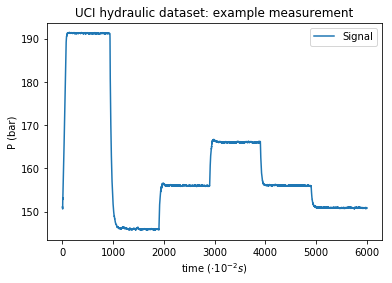

In [4]:
_, ax1 = plt.subplots()
ax1.set_title('UCI hydraulic dataset: example measurement')
ax1.plot(signal, label='Signal')
ax1.set_ylabel('P (bar)')
ax1.set_xlabel('time ($\cdot 10^{-2}s$)')
ax1.legend();

Clearly, we have six phases where the signal is stationary (constant with some noise, to put it simply). 

Note, that the changes are **not abrupt** from one point to another. This is due to the experimental setup. Obviously, a change of the valve does not change the pressure in the whole system immideately. Let's soom in a little bit to see what we mean:

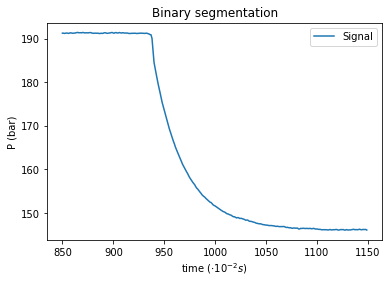

In [5]:
zoom_intervall = np.arange(850,1150)
_, ax1 = plt.subplots()
ax1.set_title('Binary segmentation')
ax1.plot(zoom_intervall,signal[zoom_intervall], label='Signal')
ax1.set_ylabel('P (bar)')
ax1.set_xlabel('time ($\cdot 10^{-2}s$)')
ax1.legend();

## 2) Detecting changes that do not occur abruptly

In the plot above, we can actually see two changepoints: one at the top at around 950 and the other between 1,000 and 1,050 (when the signal is reaching a  constant phase).

If we consider the whole signal (first plot) we have actually 13 phases, which is indeed the case if we study the description of the experiment (Hedwig et al.). 

To detect 13 phases we need 12 changepoints. The first change at the very beginning might not be detected since there is no constant phase there. Hence, we will try to detect ***11 changepoints***.

As the *binary segmentation method* is a well established method to detect changes in mean we try it out take a look at the result: 

In [6]:
algo = rpt.Binseg(model="l2").fit(signal)
my_bkps = algo.predict(n_bkps=11)
print('Detected changepoints:')
print(my_bkps)

Detected changepoints:
[25, 50, 65, 940, 950, 990, 1920, 2915, 3910, 3945, 4915, 6000]


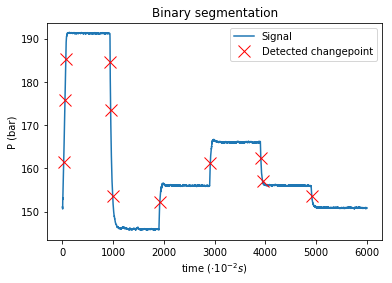

In [7]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Binary segmentation')
ax1.plot(signal, label='Signal')
ax1.set_ylabel('P (bar)')
ax1.set_xlabel('time ($\cdot 10^{-2}s$)')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

Well, the result is not what we we would like to have. Actually, we would like to get two changepoints for each segment, as described above. But we have some "overlapping", i.e. too much changepoints in the region where we would expect to get only one changepoint.

This is beacuse the cost function "l2" assumes an abrupt change in a normal distribution. Hence, a change in the cost function in a more generic one should improve the result. To avoid the "overlapping" we also add a "min_size" which forces the search method to leave some space (data points) between the changepoints.

More information about the concept of the cost functions can be found in (Truong et al. 2018).

Let's try the following tuning and take a look at the result:

- add min_size
- change cost function (kernelized mean change cost function).

*The following calculation may take a few seconds!*

In [8]:
algo = rpt.Binseg(model="rbf",min_size=50).fit(signal)
my_bkps = algo.predict(n_bkps=11)
print('Detected changepoints:')
print(my_bkps)

Detected changepoints:
[60, 115, 945, 1000, 1055, 1915, 2910, 2965, 3915, 3970, 4910, 6000]


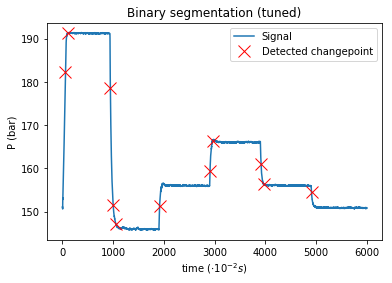

In [9]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Binary segmentation (tuned)')
ax1.plot(signal, label='Signal')
ax1.set_ylabel('P (bar)')
ax1.set_xlabel('time ($\cdot 10^{-2}s$)')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

Clearly we have two issues:

- long runtime (which can be neglected if this does not matter in your application)
- the tuning of the search method was not satisfying (hence, we need to **select a different** search method).

### Selecting a different search method

Obviously, the result of the *binary segmentation method* is not far away from the changepoints we desire. The *bottom-up method* often yields similar results. Therefore, let's do the following:

- use *bottom-up method* instead of *binary segmentation method*
- take cost function "rbf" (improves a lot, see above)
- add a min_size.

In [10]:
algo = rpt.BottomUp(model="rbf",min_size=50).fit(signal)
my_bkps = algo.predict(n_bkps=11)
print('Detected changepoints:')
print(my_bkps)

Detected changepoints:
[90, 935, 1030, 1875, 1965, 2905, 3000, 3840, 3935, 4875, 4965, 6000]


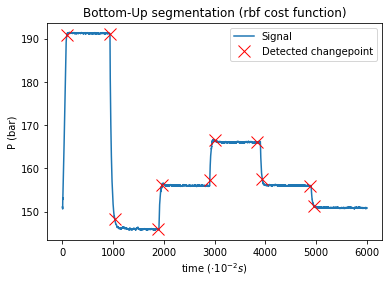

In [11]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Bottom-Up segmentation (rbf cost function)')
ax1.plot(signal, label='Signal')
ax1.set_ylabel('P (bar)')
ax1.set_xlabel('time ($\cdot 10^{-2}s$)')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

Actuall, that looks quite pleasant.

Let's zoom in again:

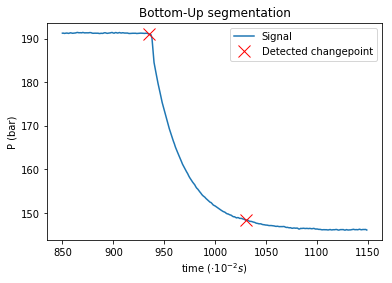

In [12]:
zoom_intervall = np.arange(850,1150)
_, ax1 = plt.subplots()
ax1.set_title('Bottom-Up segmentation')
ax1.plot(zoom_intervall,signal[zoom_intervall], label='Signal')
ax1.set_ylabel('P (bar)')
ax1.set_xlabel('time ($\cdot 10^{-2}s$)')
ax1.plot(my_bkps[1:3],signal[my_bkps[1:3]], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

Now, we have the changepoints as we would like to have them.

Note, that is was necessary to **select a different** search method to get an accurate result. Tuning the *binary segmentation method* was not sufficient.

## 3) Other changes

The UCI hydrauic dataset has further data where we can find changes, but these changes are not have changes in mean. 

Let's read and look at one of these datasets:

In [13]:
df = pd.read_csv( "FS1.txt", header=None, delimiter='\t')
signal=df.iloc[1].values
print(signal.shape)# should be (600,) for FS1.txt

(600,)


Let's plot the data:

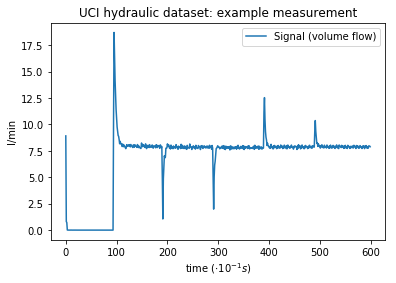

In [14]:
_, ax1 = plt.subplots()
ax1.set_title('UCI hydraulic dataset: example measurement')
ax1.plot(signal, label='Signal (volume flow)')
ax1.set_ylabel('l/min')
ax1.set_xlabel('time ($\cdot 10^{-1}s$)')
ax1.legend();

Clearly, we do not have changes in mean any more. The changes look like peaks. 

As usual, we try out the binary segmentation and take a look at the result:

In [15]:
algo = rpt.Binseg(model="l2").fit(signal)
my_bkps = algo.predict(n_bkps=6)
print('Detected changepoints:')
print(my_bkps)

Detected changepoints:
[5, 90, 95, 100, 105, 390, 600]


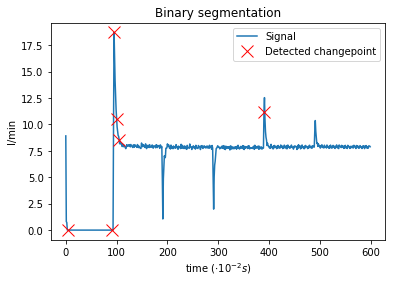

In [16]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Binary segmentation')
ax1.plot(signal, label='Signal')
ax1.set_ylabel('l/min')
ax1.set_xlabel('time ($\cdot 10^{-2}s$)')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

### Tuning the search method

The changepoints are discovered at the peaks. That does not make much sense at all. To fix this, we make sure that the algorithms will leave enough space (i.e. datapoints) between the changepoints. Let's **tune** the method with the following:

- add a min_size
- change to cost function to "normal" (cost function that "checks" if there is a change in the distribution)

In [17]:
# tuning: change cost function; also add min_size
algo = rpt.Binseg(model="normal",min_size=50).fit(signal)
my_bkps = algo.predict(n_bkps=6)
print('Detected changepoints:')
print(my_bkps)

Detected changepoints:
[100, 190, 295, 395, 500, 600]


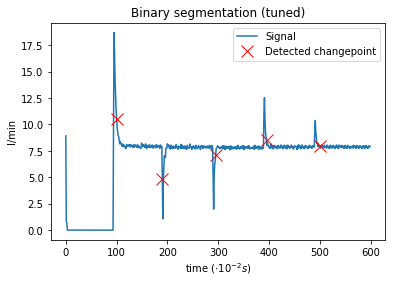

In [18]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Binary segmentation (tuned)')
ax1.plot(signal, label='Signal')
ax1.set_ylabel('l/min')
ax1.set_xlabel('time ($\cdot 10^{-2}s$)')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

That looks more satisfying. Note, that in this case we only had to **tune** the search method, whereas in the upper case we needed to **select a different** search method.

Finally, we have one last issue we want to consider: the changepoints are detected with some *delay*, i.e. after the peak occured. Let's see if we can get rid of this in the following section.

### How to avoid a delay

As just mentioned, the *binary segmentation method* detects the peaks with a *delay*. This is the case for many changepoint algorithms.

The delay could be a problem in application (it might be tha case that you want to detect a changepoint as soon as possible). Therefore, let's consider one last approach: the *window-based method*.

Let's try it out and consider the result:

In [19]:
algo = rpt.Window(width=40,model="normal",min_size=50).fit(signal)
my_bkps = algo.predict(n_bkps=6)
print('Detected changepoints:')
print(my_bkps)

Detected changepoints:
[20, 90, 185, 290, 380, 490, 600]


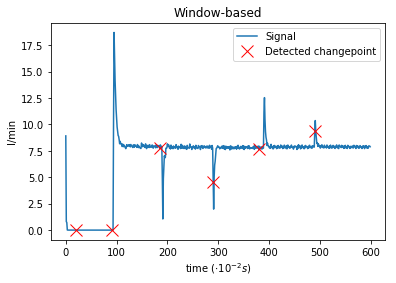

In [20]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Window-based')
ax1.plot(signal, label='Signal')
ax1.set_ylabel('l/min')
ax1.set_xlabel('time ($\cdot 10^{-2}s$)')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

As we can see, the *window-based method* tends to detect the changes before the actual change happens (however, it does not work in any case). That is more satisfying than the *binary segmentaion method*, however, it is still not optimal. But we have seen that the *window-based method* has some advantages.

## 4) Discussion

We have seen, that there are different types of changes and different approaches to detect these kind of changes. It depends on the application (and knowledge about your data) which methods you choose. Hoever, there is no straight-forward way to identify the right method.

A crucial point is, that sometimes it is sufficient to **tune** a method. But it can be a long process and you need to try many different parameters until you reach a pleasant result. And sometimes you even need **select a different** method.

### Summary

Let's summarize some recommendations how to find a suitable changepoint method. We also include some ideas from our [previous blog](./CP-detection2-runtime-aspects.ipynb):

**Recommendation how to find a suitable method to detect changepoints:**

- Do you know how many changepoints you have?
 - Yes: provide "n_bks"
 - No: provide "penalty"
- Do you need a short runtime (or even online application)?
 - Yes: choose *binary segmentation*
 - No: choose *dynamic programming*
- Are the changepoints in the desired area?
 - Yes: STOP
 - No: change the cost function OR add "min_size"
- Is the result getting better?
 - Yes: try different values for fine-tuning
 - No: try a different search method.

## 5) Literature

- Nikolai Helwig, Eliseo Pignanelli, Andreas Schütze, ‘Condition Monitoring of a Complex Hydraulic System Using Multivariate Statistics’, in Proc. I2MTC-2015 - 2015 IEEE International Instrumentation and Measurement Technology Conference, paper PPS1-39, Pisa, Italy, May 11-14, 2015, doi: 10.1109/I2MTC.2015.7151267.
- Truong, Charles; Oudre, Laurent; Vayatis, Nicolas (2018): Selective review of offline change point detection methods.
